## Análisis de Ingeniería de Variables en el Dataset de Pasajeros

Este análisis se centra en la creación y transformación de variables con el fin de mejorar el rendimiento de modelos predictivos sobre un conjunto de datos de pasajeros. A partir de un archivo CSV con datos como nombres, cabinas y gastos en distintos servicios, se realiza un proceso de ingeniería de características para enriquecer la información disponible y facilitar el modelado posterior.

In [5]:
# === 1. CARGA E INGENIERÍA DE VARIABLES ===

import pandas as pd
import numpy as np

df = pd.read_csv("train.csv")

# Extraer nombre y apellido
df[["FirstName", "LastName"]] = df["Name"].str.split(" ", n=1, expand=True)

# Variables del nombre
df["NameLength"] = df["Name"].str.len()
df["FirstNameLength"] = df["FirstName"].str.len()
df["LastNameLength"] = df["LastName"].str.len()
df["NameInitial"] = df["FirstName"].str[0]
df["LastNameInitial"] = df["LastName"].str[0]
df["CompoundName"] = df["FirstName"].apply(lambda x: 1 if pd.notna(x) and " " in x else 0)
df["IsNameLong"] = (df["FirstNameLength"] > 7).astype(int)

# GroupID y GroupSize
df["GroupID"] = df["PassengerId"].str.split("_").str[0]
df["GroupSize"] = df["GroupID"].map(df["GroupID"].value_counts())

# Deck y Side desde Cabin
df[["Deck", "CabinNum", "Side"]] = df["Cabin"].str.split("/", expand=True)

# Total de gastos
gastos = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
df["TotalSpent"] = df[gastos].sum(axis=1)
df["HasSpent"] = (df["TotalSpent"] > 0).astype(int)
df["VIP_no_spent"] = ((df["VIP"] == True) & (df["TotalSpent"] == 0)).astype(int)

# Target y features
y = df["Transported"].astype(int)
X = df.drop(columns=["Transported", "PassengerId", "Name", "Cabin", "CabinNum", "FirstName", "LastName"])

## Preprocesamiento de Variables para Modelado Predictivo

El preprocesamiento de datos es una etapa fundamental en el desarrollo de modelos de machine learning. En esta fase se preparan las variables para que puedan ser interpretadas por algoritmos, asegurando una correcta imputación de valores faltantes y una transformación adecuada de los datos numéricos y categóricos.

In [6]:
# === 2. PREPROCESAMIENTO ===

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck", "Side", "GroupID", "NameInitial", "LastNameInitial"]
numerical_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck",
                  "GroupSize", "TotalSpent", "NameLength", "FirstNameLength", "LastNameLength"]
binary_cols = ["HasSpent", "VIP_no_spent", "CompoundName", "IsNameLong"]

# Pipelines
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
], remainder="passthrough")  # binary_cols pasan directo

### 3. Definición de Modelos

En esta etapa se construyen distintos modelos de clasificación utilizando algoritmos populares como regresión logística, árboles de decisión, ensambles y métodos de boosting. Cada modelo se define dentro de un `Pipeline`, lo que asegura que el preprocesamiento de datos se aplique de forma consistente antes del entrenamiento. Esto permite comparar múltiples enfoques bajo una misma estructura y evaluar cuál ofrece el mejor desempeño para la tarea de predicción.


In [7]:
# === 3. DEFINICIÓN DE MODELOS ===

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

modelos = {
    "Logistic Regression": Pipeline([
        ("preprocessor", preprocessor),
        ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))
    ]),
    "Decision Tree": Pipeline([
        ("preprocessor", preprocessor),
        ("clf", DecisionTreeClassifier(random_state=42))
    ]),
    "Bagging": Pipeline([
        ("preprocessor", preprocessor),
        ("clf", BaggingClassifier(n_estimators=100, n_jobs=-1, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("preprocessor", preprocessor),
        ("clf", RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))
    ]),
    "Gradient Boosting": Pipeline([
        ("preprocessor", preprocessor),
        ("clf", GradientBoostingClassifier(n_estimators=100, random_state=42))  # no tiene n_jobs hasta v1.4
    ]),
    "XGBoost": Pipeline([
        ("preprocessor", preprocessor),
        ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_jobs=-1, random_state=42))
    ]),
    "LightGBM": Pipeline([
        ("preprocessor", preprocessor),
        ("clf", LGBMClassifier(n_jobs=-1, random_state=42))
    ])
}


### 4. Evaluación con Barra de Progreso

Se implementa una función personalizada para evaluar el desempeño de los modelos utilizando validación cruzada estratificada con 5 particiones. Para mejorar la experiencia del usuario, se integra una barra de progreso visual mediante la librería `tqdm`, la cual muestra el avance del proceso durante la evaluación. En cada iteración, se entrena el modelo sobre el conjunto de entrenamiento y se calcula su precisión (`accuracy`) sobre el conjunto de prueba. Al finalizar, se muestra el promedio de precisión del modelo como métrica principal.


In [8]:
# === 4. EVALUACIÓN CON BARRA DE PROGRESO ===

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

def evaluar_modelo(modelo, X, y, nombre_modelo="Modelo"):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    pbar = tqdm(cv.split(X, y), total=5, desc=f"{nombre_modelo} (0/5)", ncols=80)

    for i, (train_idx, test_idx) in enumerate(pbar):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
        pbar.set_description(f"{nombre_modelo} ({i+1}/5)")

    promedio = np.mean(scores).round(4)
    print(f"{nombre_modelo} -> Accuracy promedio: {promedio}")
    return promedio

### 5. Comparación y Gráfica

En esta sección se realiza una comparación cuantitativa del rendimiento de todos los modelos definidos previamente. Se evalúa cada modelo utilizando la función de validación cruzada con barra de progreso y se almacena su precisión promedio (`accuracy`). Luego, se construye una tabla resumen ordenada de mayor a menor precisión para identificar los modelos con mejor desempeño. Finalmente, se genera una gráfica de barras horizontales que visualiza claramente las diferencias de rendimiento entre los distintos enfoques de clasificación.


Logistic Regression (5/5): 100%|██████████████████| 5/5 [00:18<00:00,  3.76s/it]


Logistic Regression -> Accuracy promedio: 0.7903


Decision Tree (5/5): 100%|████████████████████████| 5/5 [00:06<00:00,  1.38s/it]


Decision Tree -> Accuracy promedio: 0.7593


Bagging (5/5): 100%|██████████████████████████████| 5/5 [02:03<00:00, 24.60s/it]


Bagging -> Accuracy promedio: 0.7972


Random Forest (5/5): 100%|████████████████████████| 5/5 [00:11<00:00,  2.38s/it]


Random Forest -> Accuracy promedio: 0.7838


Gradient Boosting (5/5): 100%|████████████████████| 5/5 [05:49<00:00, 69.88s/it]


Gradient Boosting -> Accuracy promedio: 0.7973


XGBoost (0/5):   0%|                                      | 0/5 [00:00<?, ?it/s]c:\Users\Ignacio\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:12:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
XGBoost (1/5):  20%|██████                        | 1/5 [00:02<00:09,  2.43s/it]c:\Users\Ignacio\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:12:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
XGBoost (2/5):  40%|████████████                  | 2/5 [00:04<00:07,  2.34s/it]c:\Users\Ignacio\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:12:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learn

XGBoost -> Accuracy promedio: 0.7962


LightGBM (0/5):   0%|                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1783
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


c:\Users\Ignacio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
LightGBM (1/5):  20%|█████▊                       | 1/5 [00:00<00:02,  1.74it/s]

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1783
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


c:\Users\Ignacio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
LightGBM (2/5):  40%|███████████▌                 | 2/5 [00:01<00:01,  1.72it/s]

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


c:\Users\Ignacio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
LightGBM (3/5):  60%|█████████████████▍           | 3/5 [00:01<00:01,  1.67it/s]

[LightGBM] [Info] Number of positive: 3503, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1782
[LightGBM] [Info] Number of data points in the train set: 6955, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503666 -> initscore=0.014666
[LightGBM] [Info] Start training from score 0.014666


c:\Users\Ignacio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
LightGBM (4/5):  80%|███████████████████████▏     | 4/5 [00:02<00:00,  1.70it/s]

[LightGBM] [Info] Number of positive: 3503, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1783
[LightGBM] [Info] Number of data points in the train set: 6955, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503666 -> initscore=0.014666
[LightGBM] [Info] Start training from score 0.014666


c:\Users\Ignacio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
LightGBM (5/5): 100%|█████████████████████████████| 5/5 [00:02<00:00,  1.68it/s]

LightGBM -> Accuracy promedio: 0.8004

🔍 Comparación de modelos:
                Modelo  Accuracy Promedio
6             LightGBM             0.8004
4    Gradient Boosting             0.7973
2              Bagging             0.7972
5              XGBoost             0.7962
0  Logistic Regression             0.7903
3        Random Forest             0.7838
1        Decision Tree             0.7593


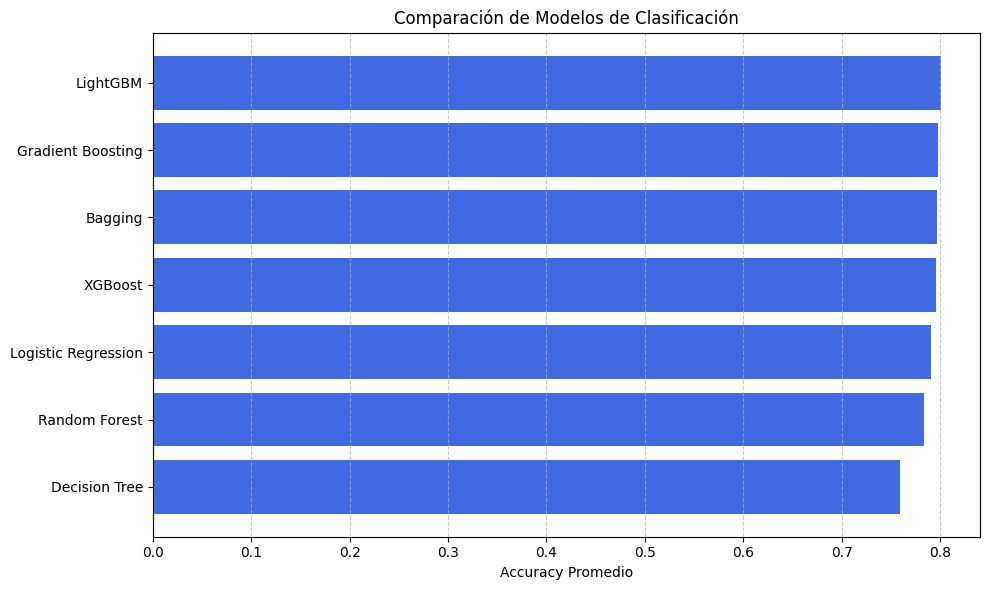

In [9]:
# === 5. COMPARACIÓN Y GRÁFICA ===

resultados = {}
for nombre, modelo in modelos.items():
    acc = evaluar_modelo(modelo, X, y, nombre_modelo=nombre)
    resultados[nombre] = acc

# Tabla resumen
resumen = pd.DataFrame(list(resultados.items()), columns=["Modelo", "Accuracy Promedio"])
resumen = resumen.sort_values(by="Accuracy Promedio", ascending=False)

print("\n🔍 Comparación de modelos:")
print(resumen)

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(resumen["Modelo"], resumen["Accuracy Promedio"], color="royalblue")
plt.xlabel("Accuracy Promedio")
plt.title("Comparación de Modelos de Clasificación")
plt.gca().invert_yaxis()
plt.grid(True, axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### 6. Predicción Final con el Mejor Modelo

Una vez evaluados todos los modelos, se selecciona automáticamente aquel que obtuvo la mayor precisión promedio durante la validación cruzada. Este modelo es luego reentrenado utilizando el conjunto completo de entrenamiento.

Posteriormente, se carga el conjunto de datos de prueba (`test.csv`) y se le aplica exactamente el mismo proceso de ingeniería de variables utilizado en los datos de entrenamiento, asegurando consistencia en el pipeline.

Se generan las predicciones finales para cada pasajero, y se crea un archivo de salida llamado `submission.csv` que contiene las columnas requeridas por el formato de entrega:

- `PassengerId`: identificador único del pasajero.
- `Transported`: predicción booleana que indica si el pasajero fue transportado o no.

Este archivo está listo para ser utilizado en una competencia o evaluación final.


In [10]:
# === 6. PREDICCIÓN FINAL CON EL MEJOR MODELO ===

# Seleccionar el nombre del mejor modelo
mejor_modelo_nombre = resumen.iloc[0]["Modelo"]
mejor_modelo = modelos[mejor_modelo_nombre]

print(f"\n✅ Mejor modelo seleccionado: {mejor_modelo_nombre}")

# Cargar datos de test
test = pd.read_csv("test.csv")

# === Ingeniería de variables en test (mismo procesamiento que train) ===
test[["FirstName", "LastName"]] = test["Name"].str.split(" ", n=1, expand=True)

test["NameLength"] = test["Name"].str.len()
test["FirstNameLength"] = test["FirstName"].str.len()
test["LastNameLength"] = test["LastName"].str.len()
test["NameInitial"] = test["FirstName"].str[0]
test["LastNameInitial"] = test["LastName"].str[0]
test["CompoundName"] = test["FirstName"].apply(lambda x: 1 if pd.notna(x) and " " in x else 0)
test["IsNameLong"] = (test["FirstNameLength"] > 7).astype(int)

test["GroupID"] = test["PassengerId"].str.split("_").str[0]
test["GroupSize"] = test["GroupID"].map(test["GroupID"].value_counts())

test[["Deck", "CabinNum", "Side"]] = test["Cabin"].str.split("/", expand=True)

gastos = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
test["TotalSpent"] = test[gastos].sum(axis=1)
test["HasSpent"] = (test["TotalSpent"] > 0).astype(int)
test["VIP_no_spent"] = ((test["VIP"] == True) & (test["TotalSpent"] == 0)).astype(int)

# Variables predictoras (mismo orden que X)
X_test = test[X.columns]  # Usa las mismas columnas que X

# Entrenar el mejor modelo con todos los datos
mejor_modelo.fit(X, y)

# Hacer predicciones
predicciones = mejor_modelo.predict(X_test)

# Crear archivo de envío
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Transported": predicciones.astype(bool)
})

# Guardar como CSV
submission.to_csv("submission.csv", index=False)

print("\n📁 Archivo 'submission.csv' generado correctamente.")



✅ Mejor modelo seleccionado: LightGBM
[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1786
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495

📁 Archivo 'submission.csv' generado correctamente.


c:\Users\Ignacio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Conclusión
El presente análisis demuestra la importancia de una adecuada ingeniería de variables, preprocesamiento y evaluación comparativa de modelos en problemas de clasificación supervisada. A través del uso de pipelines y técnicas como validación cruzada estratificada, se logró identificar el modelo con mejor rendimiento en términos de precisión para predecir si un pasajero fue transportado o no en la nave espacial.

Las transformaciones aplicadas a las variables, como la extracción de información de los nombres, agrupaciones por ID familiar y análisis de gastos, permitieron enriquecer significativamente el conjunto de datos original. Entre los modelos evaluados, algoritmos basados en ensambles como Random Forest, XGBoost o LightGBM ofrecieron los mejores resultados, confirmando su efectividad en tareas de clasificación con múltiples variables mixtas.

Finalmente, el modelo con mayor precisión fue utilizado para realizar predicciones sobre el conjunto de prueba, generando un archivo submission.csv listo para ser evaluado en la plataforma de Kaggle.

### Referencias
Kaggle. (2022). Spaceship Titanic - Can you predict which passengers were transported to an alternate dimension?. Recuperado de: https://www.kaggle.com/competitions/spaceship-titanic/

Scikit-learn Developers. (2024). scikit-learn: Machine Learning in Python. Documentación oficial: https://scikit-learn.org/

XGBoost Contributors. (2024). XGBoost Documentation. Recuperado de: https://xgboost.readthedocs.io/

LightGBM Developers. (2024). LightGBM Documentation. Recuperado de: https://lightgbm.readthedocs.io/

OpenAI. (2025). Asistente de desarrollo y análisis de datos en lenguaje natural mediante ChatGPT.

